# Importing necessary packages and defining plot functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from math import *

In [2]:
%matplotlib inline
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['figure.figsize'] = 10,10
plt.rcParams['font.size'] = 20

In [3]:
Lg=4729599

def norm_affine(v,vmin,vmax,rmin,rmax):
    #affine transformation of a signal varying between vmin and vmax such that it ends varying between rmin and rmax
    return rmin+(v-vmin)*(rmax-rmin)/(vmax-vmin)

def genom2polarData(fi,rmin=1,rmax=1.5,L=Lg):
    wlines=[line for line in open(fi).readlines() if line[0]!='#']

    #thetas
    positions=[float(line.split()[0]) for line in wlines]
    thetas=[p/L*2*np.pi for p in positions]

    #rs
    values=[float(line.split()[1]) for line in wlines]
    vmin,vmax=np.min(values),np.max(values)    
    rs=[norm_affine(v,vmin=vmin,vmax=vmax,rmin=rmin,rmax=rmax) for v in values]    
    
    return thetas,rs


def add_genomData(fi,rmin=1,rmax=1.5,L=Lg,color='C0',label=''):
    
    #baseline
    thetas=np.arange(0,2*np.pi,0.01)
    rs=np.array([rmin for t in thetas])
    plt.plot(thetas,rs,lw=2,color=color)
    
    #data
    thetas,rs=genom2polarData(fi,rmin=rmin,rmax=rmax,L=Lg)
    plt.plot(thetas,rs,lw=2,color=color,label=label) 

# Opening the GenomeDiff files

In [4]:
data = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/LTEE-clone-curated/"

In [5]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(data) if isfile(join(data, f))] #listing all file names for the .gd files
files = [] # creating a list that will first contain these names to be called, and later on open .gd files
file_names = [] # list that will contain names as strings (kept as such for all the analysis)
readlines_names = [] #list that will contain lists with the lines of each file (obtained via readlines())
for i in onlyfiles: #fixing an error in the list of files (I don't know why it occurs) and filling the previously defined lists
    if len(i) < 30:
        files.append(i)
        file_names.append(i)
        readlines_names.append(i)

In [6]:
for i in range(len(files)):
    files[i] = open(data+files[i],"r") #the list files becomes a list of open files
    readlines_names[i] = files[i].readlines() # the list readlines_names becomes a list of lists, with each list containing 
    #all the lines from one file

# Extracting insertions events

In [7]:
insertion_lines = {} # Creating a dictionary to hold all the insertions found in each file
for file_name in file_names: # Creating one entry per file in the dictionary (an empty list)
    insertion_lines[file_name] = []
for i in range(len(file_names)): # for each file
    for line in readlines_names[i]: #we look at all the lines
        line = line.split()
        if 'MOB' in line: #if one line corresponds to a mutation linked to a mobile element
            insertion_lines[file_names[i]].append(line) #we add that line to the entry of that file in the dictionary

# Analysis for IS150

## Extracting IS150 insertions

In [8]:
IS150_lines = {} # Creating a dictionary to hold all the IS150 insertions found in each file
for file_name in file_names: # Creating one entry per file in the dictionary (an empty list)
    IS150_lines[file_name] = []
for i in range(len(file_names)): # for each file
    for line in insertion_lines[file_names[i]]: #we look at all the lines
        if line[5] == 'IS150': #if the IS name entry in the line corresponds to IS150
            IS150_lines[file_names[i]].append(line) #we add that line to the entry of that file in the dictionary

## Creating a list of clone names and a list population names

In [9]:
clone_names = [] #getting the clone names without the .gd extension
for name in file_names:
    clone_names.append(name[0:len(name)-4])

In [10]:
pop_names = ["Anc-", "Anc+", "Ara+1", "Ara+2", "Ara+3", "Ara+4", "Ara+5", "Ara+6","Ara-1", "Ara-2", "Ara-3", "Ara-4", "Ara-5", "Ara-6"]
IS_data_files =  [] #creating a list to hold the names of the data files
for name in pop_names:
    IS_data_files.append("IS_data_"+name)

In [11]:
IS_data_files

['IS_data_Anc-',
 'IS_data_Anc+',
 'IS_data_Ara+1',
 'IS_data_Ara+2',
 'IS_data_Ara+3',
 'IS_data_Ara+4',
 'IS_data_Ara+5',
 'IS_data_Ara+6',
 'IS_data_Ara-1',
 'IS_data_Ara-2',
 'IS_data_Ara-3',
 'IS_data_Ara-4',
 'IS_data_Ara-5',
 'IS_data_Ara-6']

## Creating a .txt file adapted to the plot function containing the positions of the insertions for all populations (checking each clone of the population, and only counting each insertion once)

In [12]:
for pop_number in range(len(pop_names)): #for each of the studied population
    IS_data_list = [0 for j in range(floor(Lg/100000))] #we create a list to hold the number of ISs at each position
    #(we divide the genome into chunks of 100 000 pb)
    list_exact_positions = [] #listing exact positions to remove duplicates (if the exact same insertion is found in two clones, 
    # it is likely the same so we should not count it twice)
    
    for name in file_names:
        if pop_names[pop_number] in name: #if the file is one of the generations of the studied population
            for line in IS150_lines[name]:
                if line[4] not in list_exact_positions: # if we have not encountered this insertion in another clone
                    list_exact_positions.append(line[4])
                    position = floor(int(line[4])//100000)
                    IS_data_list[position] += 1 #we add one occurrence of the IS in the corresponding part of the genome

    IS_data_files[pop_number] = open(IS_data_files[pop_number]+".txt", "w") #we create a file in which we store the 
                                     # occurences of IS150 in the two clones we just analyzed
    for j in range(len(IS_data_list)):# for each position (each element of the list in which we stored occurences)                             
        pb_position = 100000*j # we recreate the approximate position (in pb)
        IS_data_files[pop_number].write(str(pb_position) + "\t" + "0" + '\n')
        IS_data_files[pop_number].write(str(pb_position + 1) + "\t" + str(IS_data_list[j]) + '\n')
        IS_data_files[pop_number].write(str(pb_position+99999) + "\t" + str(IS_data_list[j]) + '\n')
    IS_data_files[pop_number].write("4700000" + "\t" + "0" + '\n')
    IS_data_files[pop_number].close()

## Plotting the figure

c:\users\flora\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Text(0.5, 1.05, 'Distribution of IS150 insertions')

c:\users\flora\miniconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


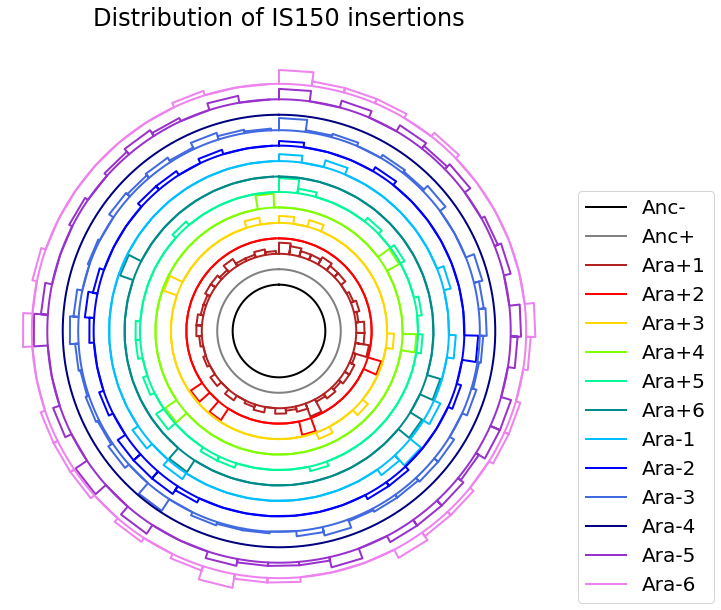

In [13]:
ax = plt.subplot(111,polar=True)
add_genomData(IS_data_files[0].name,rmin=1.5,rmax=1.95,color = "black", label=pop_names[0]) #rmin: position of the baseline
add_genomData(IS_data_files[1].name,rmin=2,rmax=2.45,color='grey',label=pop_names[1])
add_genomData(IS_data_files[2].name,rmin=2.5,rmax=2.95,color='firebrick',label=pop_names[2])
add_genomData(IS_data_files[3].name,rmin=3,rmax=3.45,color='red',label=pop_names[3])
add_genomData(IS_data_files[4].name,rmin=3.5,rmax=3.95,color='gold',label=pop_names[4])
add_genomData(IS_data_files[5].name,rmin=4,rmax=4.45,color='chartreuse',label=pop_names[5])
add_genomData(IS_data_files[6].name,rmin=4.5,rmax=4.95,color='mediumspringgreen',label=pop_names[6])
add_genomData(IS_data_files[7].name,rmin=5,rmax=5.45,color='darkcyan',label=pop_names[7])
add_genomData(IS_data_files[8].name,rmin=5.5,rmax=5.95,color='deepskyblue',label=pop_names[8])
add_genomData(IS_data_files[9].name,rmin=6,rmax=6.45,color='blue',label=pop_names[9])
add_genomData(IS_data_files[10].name,rmin=6.5,rmax=6.95,color='royalblue',label=pop_names[10])
add_genomData(IS_data_files[11].name,rmin=7,rmax=7.45,color='navy',label=pop_names[11])
add_genomData(IS_data_files[12].name,rmin=7.5,rmax=7.95,color='darkorchid',label=pop_names[12])
add_genomData(IS_data_files[13].name,rmin=8,rmax=8.45,color='violet',label=pop_names[13])

ax.set_theta_direction(-1)
plt.rgrids([]); plt.thetagrids([]); plt.axis('off');
ax.set_theta_offset(np.pi/2)

plt.legend(loc=(1.05,0))
plt.title('Distribution of IS150 insertions')

# Coding a function that does all of this when given the name of the IS you're looking for (combining all of the above)

In [14]:
def IS_positions_figure(IS_name, histo_bin_size):
    
    IS_lines={name:[line for line in insertion_lines[name] if line[5] == IS_name] for name in file_names}
                
    clone_names = []
    for name in file_names:
        clone_names.append(name[0:len(name)-4])
        
    pop_names = ["Anc-", "Anc+", "Ara+1", "Ara+2", "Ara+3", "Ara+4", "Ara+5", "Ara+6","Ara-1", "Ara-2", "Ara-3", "Ara-4", "Ara-5", "Ara-6"]
    IS_data_files =  ['IS_data_'+name for name in pop_names] #creating a list to hold the names of the data files

        
    for pop_number in range(len(pop_names)): #for each of the studied population
        IS_data_list = [0 for j in range(floor(Lg/histo_bin_size))] #we create a list to hold the number of ISs at each position
        #(we divide the genome into chunks of 100 000 pb)
        list_exact_positions = [] #listing exact positions to remove duplicates (if the exact same insertion is found in two clones, 
        # it is likely the same so we should not count it twice)

        for name in file_names:
            if pop_names[pop_number] in name: #if the file is one of the generations of the studied population
                for line in IS_lines[name]:
                    if line[4] not in list_exact_positions:
                        list_exact_positions.append(line[4])
                        position = floor(int(line[4])//histo_bin_size)
                        IS_data_list[position] += 1

        IS_data_files[pop_number] = open(IS_data_files[pop_number]+".txt", "w") #we create a file in which we store the 
                                         # occurences of IS150 in the two clones we just analyzed
        for j in range(len(IS_data_list)):# for each position (each element of the list in which we stored occurences)                             
            pb_position = histo_bin_size*j # we recreate the approximate position (in pb)
            IS_data_files[pop_number].write(str(pb_position) + "\t" + "0" + '\n')
            IS_data_files[pop_number].write(str(pb_position + 1) + "\t" + str(IS_data_list[j]) + '\n')
            IS_data_files[pop_number].write(str(pb_position+histo_bin_size-1) + "\t" + str(IS_data_list[j]) + '\n')
        IS_data_files[pop_number].write(str((Lg//histo_bin_size)*histo_bin_size) + "\t" + "0" + '\n')
        IS_data_files[pop_number].close()
    


    ax = plt.subplot(111,polar=True)
    add_genomData(IS_data_files[0].name,rmin=1.5,rmax=1.95,color = "black", label=pop_names[0]) #rmin: position of the baseline
    add_genomData(IS_data_files[1].name,rmin=2,rmax=2.45,color='grey',label=pop_names[1])
    add_genomData(IS_data_files[2].name,rmin=2.5,rmax=2.95,color='firebrick',label=pop_names[2])
    add_genomData(IS_data_files[3].name,rmin=3,rmax=3.45,color='red',label=pop_names[3])
    add_genomData(IS_data_files[4].name,rmin=3.5,rmax=3.95,color='gold',label=pop_names[4])
    add_genomData(IS_data_files[5].name,rmin=4,rmax=4.45,color='chartreuse',label=pop_names[5])
    add_genomData(IS_data_files[6].name,rmin=4.5,rmax=4.95,color='mediumspringgreen',label=pop_names[6])
    add_genomData(IS_data_files[7].name,rmin=5,rmax=5.45,color='darkcyan',label=pop_names[7])
    add_genomData(IS_data_files[8].name,rmin=5.5,rmax=5.95,color='deepskyblue',label=pop_names[8])
    add_genomData(IS_data_files[9].name,rmin=6,rmax=6.45,color='blue',label=pop_names[9])
    add_genomData(IS_data_files[10].name,rmin=6.5,rmax=6.95,color='royalblue',label=pop_names[10])
    add_genomData(IS_data_files[11].name,rmin=7,rmax=7.45,color='navy',label=pop_names[11])
    add_genomData(IS_data_files[12].name,rmin=7.5,rmax=7.95,color='darkorchid',label=pop_names[12])
    add_genomData(IS_data_files[13].name,rmin=8,rmax=8.45,color='violet',label=pop_names[13])

    ax.set_theta_direction(-1)
    plt.rgrids([]); plt.thetagrids([]); plt.axis('off');
    ax.set_theta_offset(np.pi/2)

    plt.legend(loc=(1.05,0))
    
    plt.title('Distribution of ' + IS_name + ' insertions')


# Analysis for other ISs

c:\users\flora\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


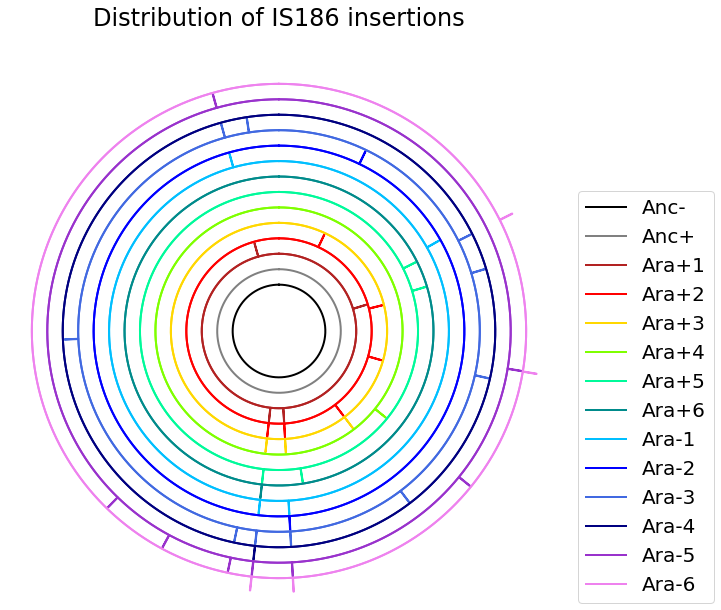

In [15]:
IS_positions_figure("IS186", histo_bin_size = 1000)

c:\users\flora\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


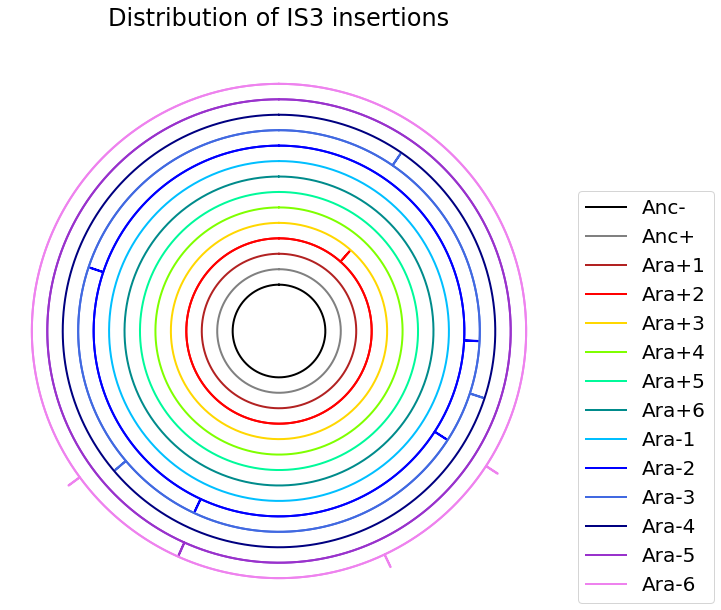

In [16]:
IS_positions_figure("IS3",  histo_bin_size = 1000)

c:\users\flora\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


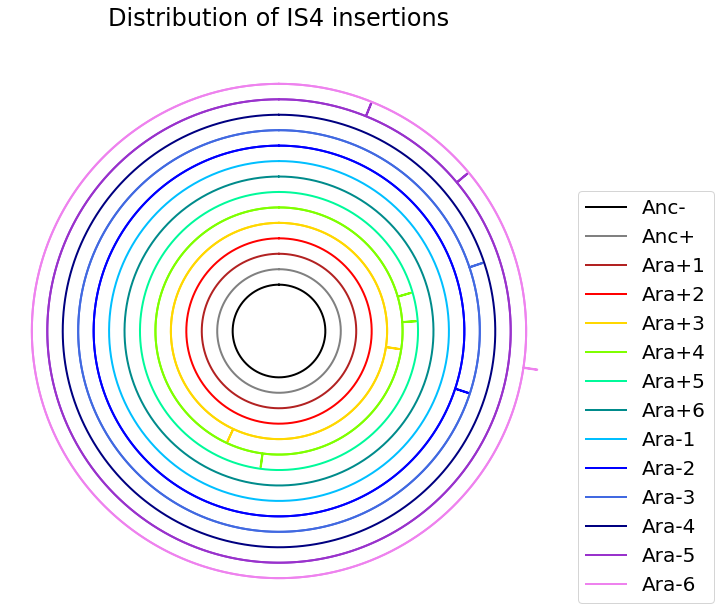

In [17]:
IS_positions_figure('IS4',  histo_bin_size = 1000)

c:\users\flora\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


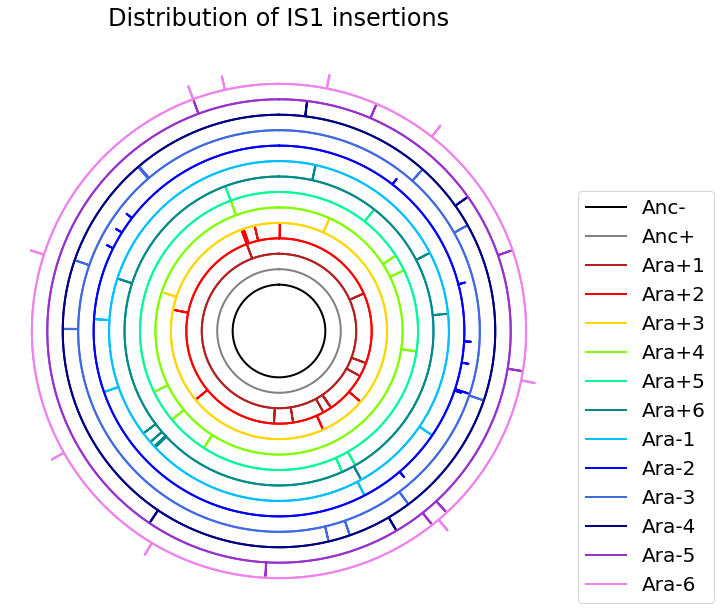

In [18]:
IS_positions_figure("IS1",  histo_bin_size = 1000)

c:\users\flora\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


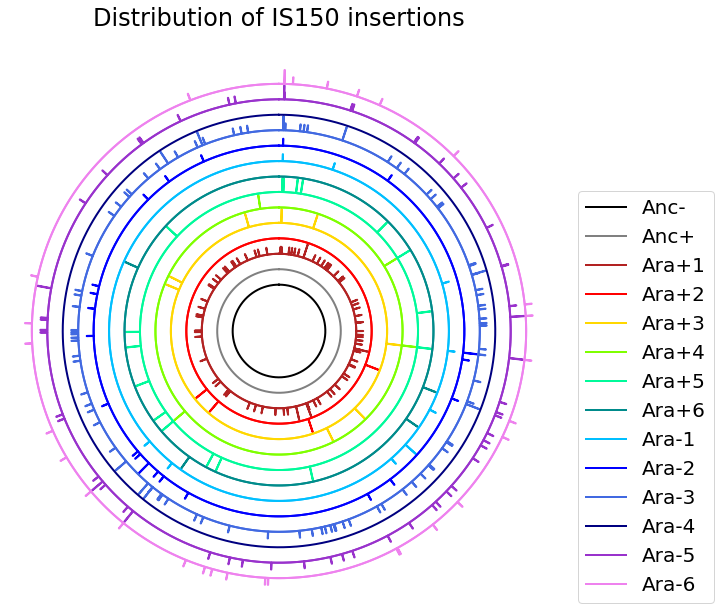

In [19]:
IS_positions_figure("IS150",  histo_bin_size = 1000)